# Diamond Regression Model

In this notebook I will be predicting the prices of diamonds based on features in the following data set.
I will be exploring the CatBoost Regressor model for my prediction.

In [148]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
#import catboost

from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor

Provided descriptions of each column from kaggle

carat Carat weight of the diamond

cut Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

color Color of the diamond, with D being the best and J the worst

clarity How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 
        inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

depthdepth % :The height of a diamond, measured from the culet to the table, divided by its average girdle diameter

tabletable %: The width of the diamond's table expressed as a percentage of its average diameter

price the price of the diamond

x    length mm

y    width mm

z    depth mm

In [149]:
# importing data set
data = pd.read_csv('diamonds.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [150]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


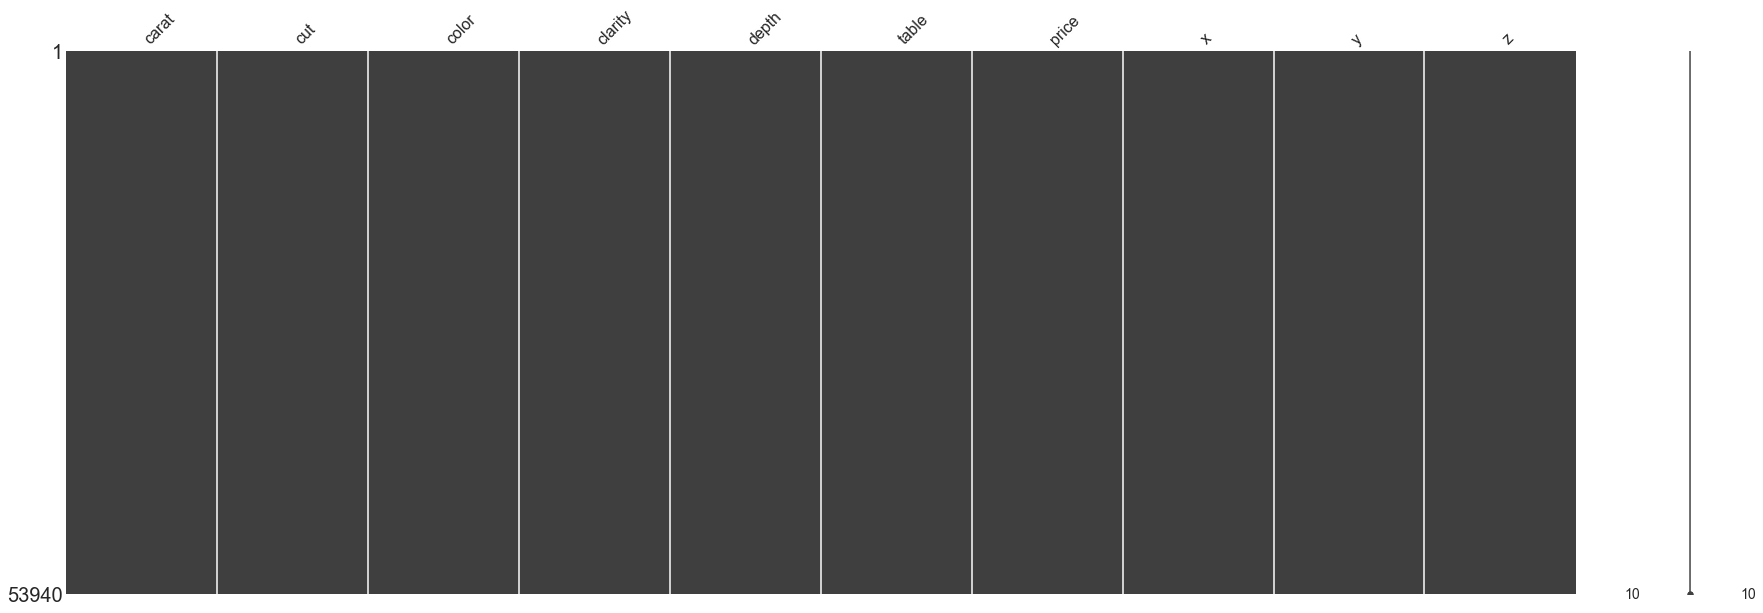

In [151]:
# Plot graphic of missing values
missingno.matrix(data, figsize = (30,10))

No missing values

In [152]:
# shuffle data as it is in price order
data = data.sample(frac=1).reset_index(drop=True)
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [153]:
data.drop_duplicates(inplace = True)

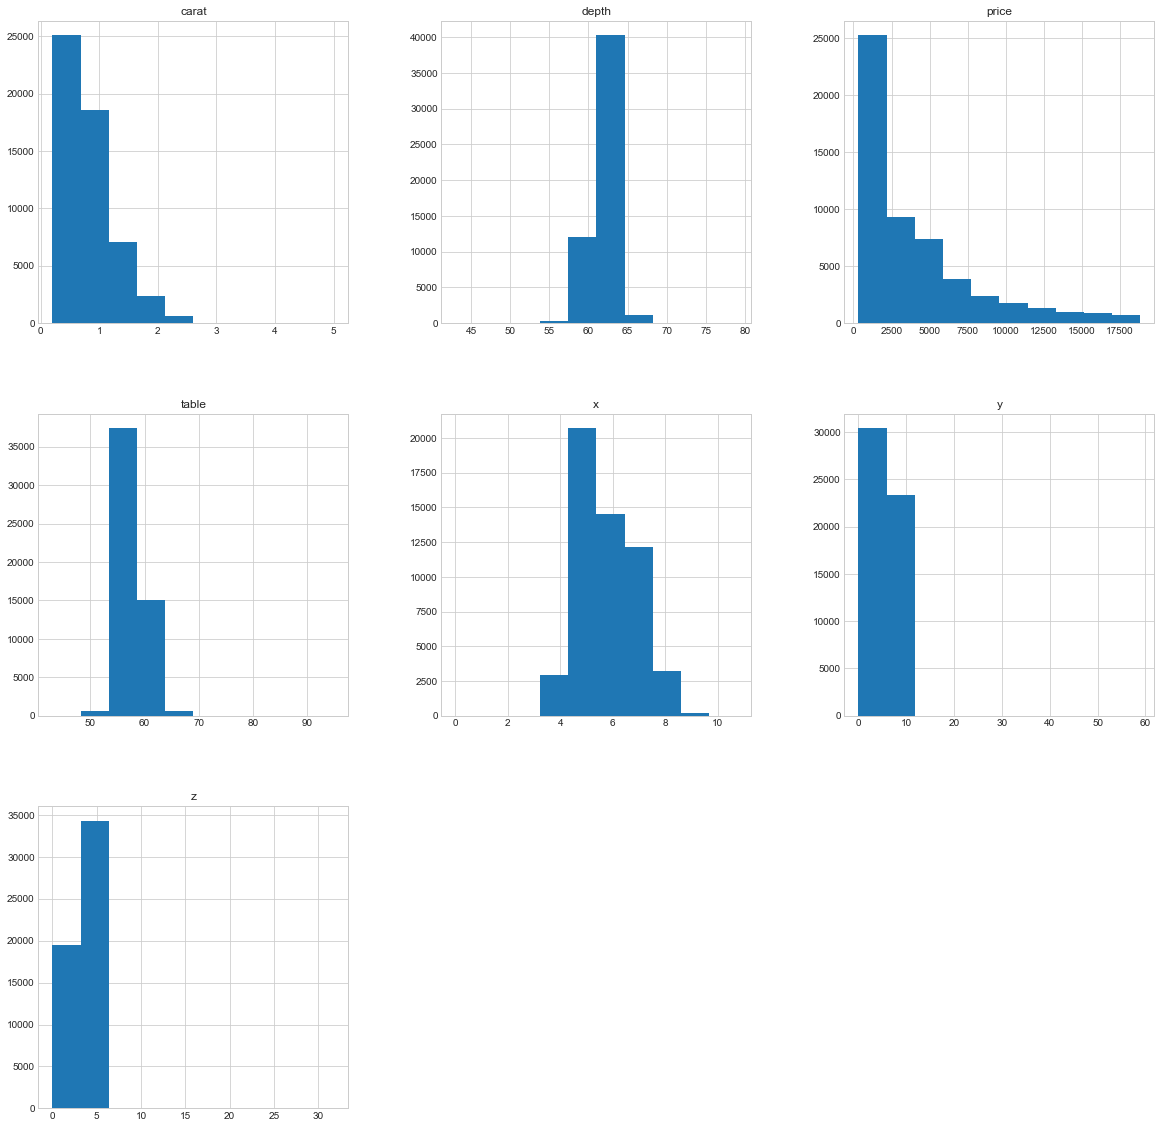

In [154]:
# Histogram plots of numerical columns
hist = data.hist(figsize=(20, 20))

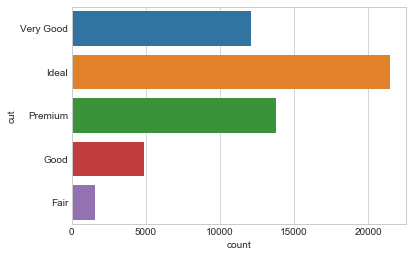

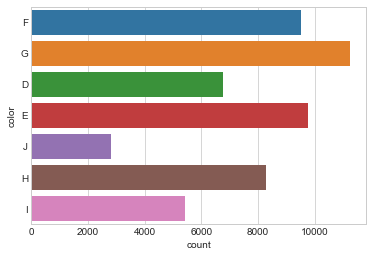

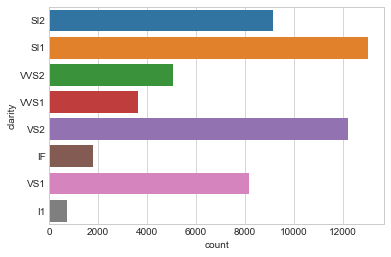

In [155]:
# count plots for categorical data
for feature in data.dtypes[data.dtypes == object].index:
    sns.countplot(y= feature, data= data)
    plt.show()

In [156]:
# creating volume column using x,y and z columns
data['Volume'] = data['x'] * data['y'] * data['z']

In [157]:
# creating carat density column 
data['Density'] = data['carat']/data['Volume']

In [158]:
# creating train set and test set
train = data[:round(len(data)*.8)]
test = data[round(len(data)*.8):]

In [159]:
# creating different dataframes for continuous data and categorical data
df_con = pd.DataFrame()
df_cat = pd.DataFrame()

In [160]:
# continuous features  
df_con['carat'] = train['carat']
df_con['depth'] = train['depth']
df_con['table'] = train['table']
df_con['x'] = train['x']
df_con['y'] = train['y']
df_con['z'] = train['z']
df_con['Volume'] = train['Volume']
df_con['Density'] = train['Density']

In [161]:
# categorical data 
df_cat['cut'] = train['cut']
df_cat['color'] = train['color']
df_cat['clarity'] = train['clarity']

In [162]:
# after combining x,y and z features I will drop them
df_con = df_con.drop(['x','y','z'], axis = 1)

In [163]:
# encode categorical features
df_cat = df_cat.apply(LabelEncoder().fit_transform)

In [164]:
# defining new dataframe with encoded categorical features and continuos features
df_train = pd.DataFrame()
df_train['price'] = train.price
df_train['cut'] = df_cat['cut']
df_train['color'] = df_cat['color']
df_train['clarity'] = df_cat['clarity']
df_train['carat'] = df_con['carat']
df_train['depth'] = df_con['depth']
df_train['table'] = df_con['table']
df_train['Volume'] = df_con['Volume']
df_train['Density'] = df_con['Density']

In [165]:
df_train.head()

,price,cut,color,clarity,carat,depth,table,Volume,Density
0,3075,4,2,3,0.71,61.4,56.0,114.841233,0.006182
1,8283,2,3,2,1.51,61.6,56.0,239.467500,0.006306
2,462,2,0,3,0.31,62.6,57.0,50.151150,0.006181
3,6085,4,2,3,1.20,62.8,55.0,194.786000,0.006161
4,567,4,1,7,0.27,59.4,64.0,43.227392,0.006246


In [166]:
# defining features, X
X = df_train.drop('price', axis = 1)

In [167]:
# defining label, y
y = df_train.price
y = np.log(y)

I have taken the log of the label(price) to help with the RMSE prediction made by the model later on 

In [168]:
# defining training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=1234)

A great feature of the CatBoost algorithm is that it can deal with categorical features which saves time creating dummy variables. Below I define my categorical columns

In [169]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

Set model parameters to avoid overfitting

In [170]:
model=CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.04, loss_function='RMSE',l2_leaf_reg=10,
                        random_strength = 100)
model.fit(X_train, y_train,
          cat_features=categorical_features_indices,
          eval_set=(X_val, y_val),
          plot=False,
         use_best_model=True)

0:	learn: 7.5462529	test: 7.5453442	best: 7.5453442 (0)	total: 39.1ms	remaining: 39.1s
1:	learn: 7.2502686	test: 7.2493731	best: 7.2493731 (1)	total: 64.6ms	remaining: 32.2s
2:	learn: 6.9634385	test: 6.9624617	best: 6.9624617 (2)	total: 101ms	remaining: 33.6s
3:	learn: 6.6869275	test: 6.6858857	best: 6.6858857 (3)	total: 133ms	remaining: 33s
4:	learn: 6.4252170	test: 6.4240496	best: 6.4240496 (4)	total: 146ms	remaining: 29.1s
5:	learn: 6.1740917	test: 6.1729316	best: 6.1729316 (5)	total: 165ms	remaining: 27.3s
6:	learn: 5.9331271	test: 5.9321437	best: 5.9321437 (6)	total: 183ms	remaining: 26s
7:	learn: 5.7023233	test: 5.7013113	best: 5.7013113 (7)	total: 202ms	remaining: 25s
8:	learn: 5.4810722	test: 5.4800896	best: 5.4800896 (8)	total: 223ms	remaining: 24.6s
9:	learn: 5.2685946	test: 5.2669349	best: 5.2669349 (9)	total: 239ms	remaining: 23.7s
10:	learn: 5.0622019	test: 5.0600057	best: 5.0600057 (10)	total: 277ms	remaining: 24.9s
11:	learn: 4.8663585	test: 4.8639513	best: 4.8639513 (11

96:	learn: 0.5017965	test: 0.5004790	best: 0.5004790 (96)	total: 2.41s	remaining: 22.5s
97:	learn: 0.4913436	test: 0.4901158	best: 0.4901158 (97)	total: 2.45s	remaining: 22.5s
98:	learn: 0.4811326	test: 0.4798775	best: 0.4798775 (98)	total: 2.47s	remaining: 22.5s
99:	learn: 0.4713189	test: 0.4700017	best: 0.4700017 (99)	total: 2.5s	remaining: 22.5s
100:	learn: 0.4589127	test: 0.4575207	best: 0.4575207 (100)	total: 2.53s	remaining: 22.6s
101:	learn: 0.4479219	test: 0.4464829	best: 0.4464829 (101)	total: 2.56s	remaining: 22.6s
102:	learn: 0.4465212	test: 0.4450766	best: 0.4450766 (102)	total: 2.58s	remaining: 22.5s
103:	learn: 0.4387749	test: 0.4373222	best: 0.4373222 (103)	total: 2.6s	remaining: 22.4s
104:	learn: 0.4310407	test: 0.4294918	best: 0.4294918 (104)	total: 2.63s	remaining: 22.4s
105:	learn: 0.4297553	test: 0.4282602	best: 0.4282602 (105)	total: 2.66s	remaining: 22.4s
106:	learn: 0.4287303	test: 0.4272455	best: 0.4272455 (106)	total: 2.69s	remaining: 22.4s
107:	learn: 0.423565

193:	learn: 0.2416679	test: 0.2405646	best: 0.2405646 (193)	total: 5s	remaining: 20.8s
194:	learn: 0.2412326	test: 0.2400742	best: 0.2400742 (194)	total: 5.03s	remaining: 20.8s
195:	learn: 0.2401262	test: 0.2389999	best: 0.2389999 (195)	total: 5.05s	remaining: 20.7s
196:	learn: 0.2391561	test: 0.2380587	best: 0.2380587 (196)	total: 5.06s	remaining: 20.6s
197:	learn: 0.2374238	test: 0.2363326	best: 0.2363326 (197)	total: 5.08s	remaining: 20.6s
198:	learn: 0.2358666	test: 0.2348202	best: 0.2348202 (198)	total: 5.12s	remaining: 20.6s
199:	learn: 0.2357126	test: 0.2346709	best: 0.2346709 (199)	total: 5.15s	remaining: 20.6s
200:	learn: 0.2345981	test: 0.2335597	best: 0.2335597 (200)	total: 5.17s	remaining: 20.6s
201:	learn: 0.2341845	test: 0.2331745	best: 0.2331745 (201)	total: 5.2s	remaining: 20.6s
202:	learn: 0.2331104	test: 0.2321640	best: 0.2321640 (202)	total: 5.23s	remaining: 20.6s
203:	learn: 0.2321492	test: 0.2312221	best: 0.2312221 (203)	total: 5.26s	remaining: 20.5s
204:	learn: 0.

289:	learn: 0.1734780	test: 0.1719416	best: 0.1719416 (289)	total: 7.53s	remaining: 18.4s
290:	learn: 0.1730223	test: 0.1714986	best: 0.1714986 (290)	total: 7.56s	remaining: 18.4s
291:	learn: 0.1723099	test: 0.1707606	best: 0.1707606 (291)	total: 7.59s	remaining: 18.4s
292:	learn: 0.1722400	test: 0.1706610	best: 0.1706610 (292)	total: 7.6s	remaining: 18.3s
293:	learn: 0.1715304	test: 0.1699764	best: 0.1699764 (293)	total: 7.63s	remaining: 18.3s
294:	learn: 0.1709410	test: 0.1693584	best: 0.1693584 (294)	total: 7.65s	remaining: 18.3s
295:	learn: 0.1704869	test: 0.1688919	best: 0.1688919 (295)	total: 7.68s	remaining: 18.3s
296:	learn: 0.1702171	test: 0.1686081	best: 0.1686081 (296)	total: 7.7s	remaining: 18.2s
297:	learn: 0.1694604	test: 0.1677874	best: 0.1677874 (297)	total: 7.73s	remaining: 18.2s
298:	learn: 0.1683381	test: 0.1666879	best: 0.1666879 (298)	total: 7.76s	remaining: 18.2s
299:	learn: 0.1677797	test: 0.1661832	best: 0.1661832 (299)	total: 7.8s	remaining: 18.2s
300:	learn: 0

381:	learn: 0.1346974	test: 0.1337188	best: 0.1337188 (381)	total: 10.5s	remaining: 17s
382:	learn: 0.1345527	test: 0.1335793	best: 0.1335793 (382)	total: 10.5s	remaining: 16.9s
383:	learn: 0.1343520	test: 0.1333614	best: 0.1333614 (383)	total: 10.5s	remaining: 16.9s
384:	learn: 0.1342394	test: 0.1332596	best: 0.1332596 (384)	total: 10.6s	remaining: 16.9s
385:	learn: 0.1341624	test: 0.1332005	best: 0.1332005 (385)	total: 10.6s	remaining: 16.9s
386:	learn: 0.1336575	test: 0.1326941	best: 0.1326941 (386)	total: 10.7s	remaining: 16.9s
387:	learn: 0.1335745	test: 0.1326068	best: 0.1326068 (387)	total: 10.7s	remaining: 16.9s
388:	learn: 0.1332478	test: 0.1322776	best: 0.1322776 (388)	total: 10.7s	remaining: 16.9s
389:	learn: 0.1331362	test: 0.1321944	best: 0.1321944 (389)	total: 10.8s	remaining: 16.8s
390:	learn: 0.1330856	test: 0.1321637	best: 0.1321637 (390)	total: 10.8s	remaining: 16.8s
391:	learn: 0.1329818	test: 0.1320632	best: 0.1320632 (391)	total: 10.8s	remaining: 16.8s
392:	learn: 

474:	learn: 0.1259261	test: 0.1253138	best: 0.1253138 (474)	total: 13.6s	remaining: 15s
475:	learn: 0.1259234	test: 0.1253099	best: 0.1253099 (475)	total: 13.6s	remaining: 15s
476:	learn: 0.1258965	test: 0.1252990	best: 0.1252990 (476)	total: 13.7s	remaining: 15s
477:	learn: 0.1258963	test: 0.1252987	best: 0.1252987 (477)	total: 13.7s	remaining: 15s
478:	learn: 0.1258908	test: 0.1252958	best: 0.1252958 (478)	total: 13.7s	remaining: 14.9s
479:	learn: 0.1258895	test: 0.1252936	best: 0.1252936 (479)	total: 13.8s	remaining: 14.9s
480:	learn: 0.1258738	test: 0.1252878	best: 0.1252878 (480)	total: 13.8s	remaining: 14.9s
481:	learn: 0.1258659	test: 0.1252830	best: 0.1252830 (481)	total: 13.8s	remaining: 14.9s
482:	learn: 0.1258380	test: 0.1252529	best: 0.1252529 (482)	total: 13.9s	remaining: 14.8s
483:	learn: 0.1255377	test: 0.1249877	best: 0.1249877 (483)	total: 13.9s	remaining: 14.8s
484:	learn: 0.1255217	test: 0.1249707	best: 0.1249707 (484)	total: 13.9s	remaining: 14.8s
485:	learn: 0.1255

569:	learn: 0.1227346	test: 0.1223517	best: 0.1223517 (569)	total: 16.7s	remaining: 12.6s
570:	learn: 0.1227338	test: 0.1223509	best: 0.1223509 (570)	total: 16.7s	remaining: 12.6s
571:	learn: 0.1227326	test: 0.1223511	best: 0.1223509 (570)	total: 16.8s	remaining: 12.5s
572:	learn: 0.1227146	test: 0.1223379	best: 0.1223379 (572)	total: 16.8s	remaining: 12.5s
573:	learn: 0.1227068	test: 0.1223289	best: 0.1223289 (573)	total: 16.8s	remaining: 12.5s
574:	learn: 0.1227065	test: 0.1223292	best: 0.1223289 (573)	total: 16.9s	remaining: 12.5s
575:	learn: 0.1227052	test: 0.1223299	best: 0.1223289 (573)	total: 16.9s	remaining: 12.4s
576:	learn: 0.1227043	test: 0.1223303	best: 0.1223289 (573)	total: 16.9s	remaining: 12.4s
577:	learn: 0.1226957	test: 0.1223171	best: 0.1223171 (577)	total: 17s	remaining: 12.4s
578:	learn: 0.1226878	test: 0.1223161	best: 0.1223161 (578)	total: 17s	remaining: 12.4s
579:	learn: 0.1226853	test: 0.1223140	best: 0.1223140 (579)	total: 17s	remaining: 12.3s
580:	learn: 0.12

667:	learn: 0.1205429	test: 0.1203854	best: 0.1203854 (667)	total: 19.8s	remaining: 9.86s
668:	learn: 0.1205376	test: 0.1203835	best: 0.1203835 (668)	total: 19.9s	remaining: 9.83s
669:	learn: 0.1205374	test: 0.1203841	best: 0.1203835 (668)	total: 19.9s	remaining: 9.8s
670:	learn: 0.1205372	test: 0.1203840	best: 0.1203835 (668)	total: 19.9s	remaining: 9.78s
671:	learn: 0.1205341	test: 0.1203827	best: 0.1203827 (671)	total: 20s	remaining: 9.74s
672:	learn: 0.1205333	test: 0.1203820	best: 0.1203820 (672)	total: 20s	remaining: 9.72s
673:	learn: 0.1205332	test: 0.1203826	best: 0.1203820 (672)	total: 20s	remaining: 9.69s
674:	learn: 0.1205313	test: 0.1203827	best: 0.1203820 (672)	total: 20.1s	remaining: 9.66s
675:	learn: 0.1205301	test: 0.1203828	best: 0.1203820 (672)	total: 20.1s	remaining: 9.63s
676:	learn: 0.1205300	test: 0.1203828	best: 0.1203820 (672)	total: 20.1s	remaining: 9.6s
677:	learn: 0.1205231	test: 0.1203814	best: 0.1203814 (677)	total: 20.2s	remaining: 9.57s
678:	learn: 0.1205

765:	learn: 0.1194425	test: 0.1193996	best: 0.1193996 (765)	total: 22.9s	remaining: 6.99s
766:	learn: 0.1194402	test: 0.1193957	best: 0.1193957 (766)	total: 22.9s	remaining: 6.96s
767:	learn: 0.1194401	test: 0.1193962	best: 0.1193957 (766)	total: 22.9s	remaining: 6.93s
768:	learn: 0.1194389	test: 0.1193956	best: 0.1193956 (768)	total: 23s	remaining: 6.9s
769:	learn: 0.1194387	test: 0.1193955	best: 0.1193955 (769)	total: 23s	remaining: 6.87s
770:	learn: 0.1194379	test: 0.1193952	best: 0.1193952 (770)	total: 23s	remaining: 6.84s
771:	learn: 0.1194377	test: 0.1193953	best: 0.1193952 (770)	total: 23.1s	remaining: 6.81s
772:	learn: 0.1194375	test: 0.1193951	best: 0.1193951 (772)	total: 23.1s	remaining: 6.79s
773:	learn: 0.1194355	test: 0.1193949	best: 0.1193949 (773)	total: 23.1s	remaining: 6.76s
774:	learn: 0.1194344	test: 0.1193950	best: 0.1193949 (773)	total: 23.2s	remaining: 6.73s
775:	learn: 0.1194335	test: 0.1193944	best: 0.1193944 (775)	total: 23.2s	remaining: 6.7s
776:	learn: 0.1194

858:	learn: 0.1191902	test: 0.1192377	best: 0.1192353 (848)	total: 26s	remaining: 4.26s
859:	learn: 0.1191896	test: 0.1192368	best: 0.1192353 (848)	total: 26s	remaining: 4.23s
860:	learn: 0.1191880	test: 0.1192370	best: 0.1192353 (848)	total: 26s	remaining: 4.2s
861:	learn: 0.1191870	test: 0.1192368	best: 0.1192353 (848)	total: 26.1s	remaining: 4.17s
862:	learn: 0.1191868	test: 0.1192368	best: 0.1192353 (848)	total: 26.1s	remaining: 4.14s
863:	learn: 0.1191858	test: 0.1192369	best: 0.1192353 (848)	total: 26.1s	remaining: 4.11s
864:	learn: 0.1191855	test: 0.1192373	best: 0.1192353 (848)	total: 26.1s	remaining: 4.08s
865:	learn: 0.1191844	test: 0.1192368	best: 0.1192353 (848)	total: 26.2s	remaining: 4.05s
866:	learn: 0.1191832	test: 0.1192365	best: 0.1192353 (848)	total: 26.2s	remaining: 4.02s
867:	learn: 0.1191832	test: 0.1192370	best: 0.1192353 (848)	total: 26.2s	remaining: 3.99s
868:	learn: 0.1191808	test: 0.1192371	best: 0.1192353 (848)	total: 26.3s	remaining: 3.96s
869:	learn: 0.119

953:	learn: 0.1186267	test: 0.1188008	best: 0.1188003 (952)	total: 28.8s	remaining: 1.39s
954:	learn: 0.1186262	test: 0.1188003	best: 0.1188003 (954)	total: 28.8s	remaining: 1.36s
955:	learn: 0.1185852	test: 0.1187595	best: 0.1187595 (955)	total: 28.9s	remaining: 1.33s
956:	learn: 0.1185852	test: 0.1187599	best: 0.1187595 (955)	total: 28.9s	remaining: 1.3s
957:	learn: 0.1185837	test: 0.1187599	best: 0.1187595 (955)	total: 28.9s	remaining: 1.27s
958:	learn: 0.1185835	test: 0.1187601	best: 0.1187595 (955)	total: 28.9s	remaining: 1.24s
959:	learn: 0.1185835	test: 0.1187606	best: 0.1187595 (955)	total: 29s	remaining: 1.21s
960:	learn: 0.1185834	test: 0.1187611	best: 0.1187595 (955)	total: 29s	remaining: 1.18s
961:	learn: 0.1185834	test: 0.1187615	best: 0.1187595 (955)	total: 29s	remaining: 1.15s
962:	learn: 0.1185828	test: 0.1187616	best: 0.1187595 (955)	total: 29.1s	remaining: 1.12s
963:	learn: 0.1185826	test: 0.1187616	best: 0.1187595 (955)	total: 29.1s	remaining: 1.09s
964:	learn: 0.118

In [171]:
# RMSE score of model
model.score(X_train,y_train)

0.11506977518923546

In [172]:
# getting prices to check predictions against
test_prices = np.log(test.price)

In [173]:
# getting features to make predictions on
df_test = test.drop('price', axis =1)

In [174]:
# continuous features
df_test_con = df_test[df_con.columns]

In [175]:
# categorical features
df_test_cat = df_test[df_cat.columns]

In [176]:
df_test_cat = df_test_cat.apply(LabelEncoder().fit_transform)

In [177]:
# final feature dataframe for predictions
df_test_features = pd.DataFrame()
df_test_features['cut'] = df_test_cat['cut']
df_test_features['color'] = df_test_cat['color']
df_test_features['clarity'] = df_test_cat['clarity']
df_test_features['carat'] = df_test_con['carat']
df_test_features['depth'] = df_test_con['depth']
df_test_features['table'] = df_test_con['table']
df_test_features['Volume'] = df_test_con['Volume']
df_test_features['Density'] = df_test_con['Density']

In [178]:
df_test_features.head()

,cut,color,clarity,carat,depth,table,Volume,Density
43129,2,2,2,0.38,61.1,57.0,63.889920,0.005948
43130,3,2,7,0.33,62.5,59.0,54.480360,0.006057
43131,1,4,2,1.00,63.7,55.0,160.059114,0.006248
43132,1,1,2,0.50,63.8,55.0,82.861128,0.006034
43133,4,4,2,0.56,63.2,57.0,91.506172,0.006120


In [179]:
predict = model.predict(df_test_features)

In [191]:
# checking RMSE of predictions
RMSE = np.sqrt((sum((predict-test_prices)**2))/len(val))
RMSE

0.11719049476151124

Another metric to measure a Regression model is to evaluate the r-squared value

In [192]:
r2 = r2_score(test_prices,predict)
r2

0.986608801434676

# Review:

This is a quick analysis of this dataset using a CatBoost model. The models feature to handle categorical data without using dummy varibales or one hot encoding seems to be effective. The overfitting preventions also seemed to be effective as the model is able to achieve a very smiliar RMSE score on un-seen data.

# Improvements:

More feature exploration can be done.